# Welcome!

Welcome to this short demo of the Unified Planning (UP) library. In this interactive demo we will install the library itself, with four planning engines and we will showcase some of the functionalities available in the library. This demo focuses on classical and numeric planning, but the UP library is capable of temporal planning as well and more formalisms will be added soon!   

# Let's install the Unified Planning Library and three planners

Let's start by installing the library! The UP library can be installed directly from PIP with a single command.

We install also Pyperplan, Tamer, ENHSP (requires Java 17) and Fast Downward

In [ ]:
!apt-get install openjdk-17-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-17-jdk-headless openjdk-17-jre
  openjdk-17-jre-headless x11-utils
Suggested packages:
  openjdk-17-demo openjdk-17-source visualvm libnss-mdns fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
  mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-17-jdk openjdk-17-jdk-headless
  openjdk-17-jre openjdk-17-jre-headless x11-utils
0 upgraded, 10 newly installed, 0 to remove and 49 not upgraded.
Need to get 287 MB of archives.
After this operation, 453 MB

In [ ]:
!pip install unified-planning[pyperplan,tamer,enhsp,fast-downward]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 230 kB 15.3 MB/s 
     |████████████████████████████████| 52.2 MB 139 kB/s 
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
     |████████████████████████████████| 69 kB 8.0 MB/s 
     |████████████████████████████████| 2.2 MB 46.9 MB/s 


# Creating a simple robot moving problem
Suppose we are given a graph (here generated randomly) of locations each with an associated geometric position...

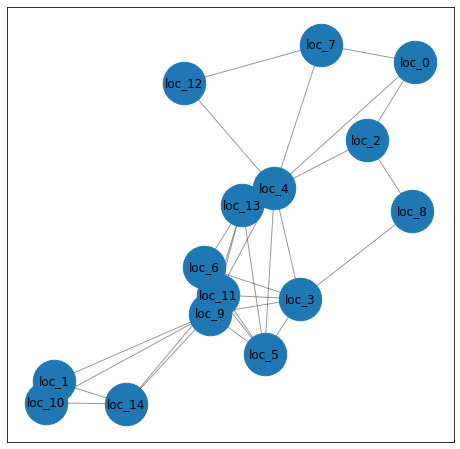

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Use seed when creating the graph for reproducibility
location_map = nx.soft_random_geometric_graph([f'loc_{i}' for i in range(15)], 0.5, seed=2)
# Position is stored as node attribute data for soft_random_geometric_graph
pos = nx.get_node_attributes(location_map, "pos")

# Show the graph
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(location_map, pos, alpha=0.4)
nx.draw_networkx_nodes(
    location_map,
    pos,
    node_size=1800
)
nx.draw_networkx_labels(location_map, pos)
plt.show()

Suppose our robot is initially in location `loc_0` and wants go go in location `loc_10`

In [ ]:
# Saving initial and goal location names in python variables
INIT = 'loc_1'  #loc_2  loc_3
DEST = 'loc_3'

In [ ]:
# disk_3 is the biggest
num_disks = 3

Items_list = ['loc_1', 'loc_2', 'loc_3']
for i in range(num_disks):
  Items_list.append(f'disk_{i+1}')
print(Items_list)

['loc_1', 'loc_2', 'loc_3', 'disk_1', 'disk_2', 'disk_3']


## Classical planning formulation

We can easily and **programmatically** create a classical planning problem directly from the graph data structure using the UP primitives

In [ ]:
from unified_planning.shortcuts import *

# First, we declare a "Location" type 
#Location = UserType('Location')
Item = UserType('Item')

# We create a new problem
problem = Problem('towersHanoi')

# Declare the fluents:
# - `robot_at` is a predicate modeling the robot position,
# - `connected` is a static fluent for modeling the graph connectivity relation
is_disk = Fluent('is_disk', BoolType(), disk_i=Item)
clear = Fluent('clear', BoolType(), disk_i=Item)
on = Fluent('on', BoolType(), disk_i=Item, disk_pos=Item)
smaller = Fluent('smaller', BoolType(), disk_i=Item, disk_j=Item)
#robot_at = Fluent('robot_at', BoolType(), position=Location)
#connected = Fluent('connected', BoolType(), l_from=Location, l_to=Location)

# Add the fluents to the problem, a Fluent can be resused in many problems
# The default values are optional and can be any value (not forcing closed-world assumption) 
#problem.add_fluent(robot_at, default_initial_value=False)
#problem.add_fluent(connected, default_initial_value=False)
problem.add_fluent(is_disk, default_initial_value=False)
problem.add_fluent(clear, default_initial_value=False)
problem.add_fluent(on, default_initial_value=False)
problem.add_fluent(smaller, default_initial_value=False)

# Create a simple `move` action  
move = InstantaneousAction('move', disk=Item, l_from=Item, l_to=Item)
disk = move.parameter('disk')
l_from = move.parameter('l_from')
l_to = move.parameter('l_to')
move.add_precondition(is_disk(disk))
move.add_precondition(smaller(disk, l_to))
move.add_precondition(on(disk, l_from))
move.add_precondition(clear(disk))
move.add_precondition(clear(l_to))
move.add_effect(clear(l_from), True)
move.add_effect(on(disk, l_to), True)
move.add_effect(on(disk, l_from), False)
move.add_effect(clear(l_to), False)
problem.add_action(move)

# Programmatically create a map from location name to a new `Object` of type `Location`
items = {str(i) : Object(str(i), Item) for i in Items_list}
#locations = {str(l) : Object(str(l), Location) for l in location_map.nodes}

# Add all the objects to the problem
problem.add_objects(items.values())

# Setting the initial location
#problem.set_initial_value(robot_at(locations[INIT]), True)
for i in range(num_disks):
  problem.set_initial_value(is_disk(items[f'disk_{i+1}']), True)
  problem.set_initial_value(on(items[f'disk_{i+1}'], items['loc_1']), True)
  if i!=num_disks-1:
    problem.set_initial_value(on(items[f'disk_{i+1}'], items[f'disk_{i+2}']), True)
    for j in range(i+1, num_disks):
      problem.set_initial_value(smaller(items[f'disk_{i+1}'], items[f'disk_{j+1}']), True)

  for k in range(3): #3 is the num_locs
    problem.set_initial_value(smaller(items[f'disk_{i+1}'], items[f'loc_{k+1}']), True)

problem.set_initial_value(clear(items['disk_1']), True)
problem.set_initial_value(clear(items['loc_2']), True)
problem.set_initial_value(clear(items['loc_3']), True)



# Initializing the connectivity relations by iterating over the graph edges
#for (f, t) in location_map.edges:
#  problem.set_initial_value(connected(locations[str(f)], locations[str(t)]), True)
#  problem.set_initial_value(connected(locations[str(t)], locations[str(f)]), True)

# Setting the goal
for i in range(num_disks-1):
  problem.add_goal(on(items[f'disk_{i+1}'], items[f'disk_{i+2}']))
problem.add_goal(on(items[f'disk_{num_disks}'], items[DEST]))

# Printing the problem data structure in human-readable form
# (We can also print in PDDL and ANML)
print(problem)

problem name = robot

types = [Location]

fluents = [
  bool robot_at[position=Location]
  bool connected[l_from=Location, l_to=Location]
]

actions = [
  action move(Location l_from, Location l_to) {
    preconditions = [
      robot_at(l_from)
      connected(l_from, l_to)
    ]
    effects = [
      robot_at(l_from) := false
      robot_at(l_to) := true
    ]
    simulated effect = None
  }
]

objects = [
  Location: [loc_0, loc_1, loc_2, loc_3, loc_4, loc_5, loc_6, loc_7, loc_8, loc_9, loc_10, loc_11, loc_12, loc_13, loc_14]
]

initial fluents default = [
  bool robot_at[position=Location] := false
  bool connected[l_from=Location, l_to=Location] := false
]

initial values = [
  robot_at(loc_0) := true
  connected(loc_0, loc_2) := true
  connected(loc_2, loc_0) := true
  connected(loc_0, loc_4) := true
  connected(loc_4, loc_0) := true
  connected(loc_0, loc_7) := true
  connected(loc_7, loc_0) := true
  connected(loc_1, loc_9) := true
  connected(loc_9, loc_1) := true
  connected(

### Solving with classical planners

We can now invoke the classical planners we have installed on our machine in a uniform and convenient way

In [ ]:
from unified_planning.engines import PlanGenerationResultStatus

for planner_name in ['pyperplan', 'fast-downward']:
  with OneshotPlanner(name=planner_name) as planner:
    result = planner.solve(problem)
    if result.status == PlanGenerationResultStatus.SOLVED_SATISFICING:
      print(f'{planner_name} found a plan.\nThe plan is: {result.plan}')
    else:
      print("No plan found.")

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_env().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 4 of `<ipython-input-6-62254759c4f6>`, you are using the following planning engine:
  * Engine name: pyperplan
  * Developers:  Artificial Intelligence Group - University of Basel
  * Description: Pyperplan is a lightweight STRIPS planner written in Python.

pyperplan found a plan.
The plan is: [move(loc_0, loc_4), move(loc_4, loc_5), move(loc_5, loc_9), move(loc_9, loc_10)]
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 4 of `<ipython-input-6-62254759c4f6>`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

fast-downward found a plan.
The plan is: [move(loc_0, 

## Extend with numerical fluents

We can easily extend our problem adding numeric fluents

In [ ]:
import math
from fractions import Fraction

# A simple function that associates a battery cost to each edge
def battery_consumption(loc_from, loc_to):
  pos = nx.get_node_attributes(location_map, "pos")
  fx, fy = pos[loc_from]
  tx, ty = pos[loc_to]
  distance = math.sqrt((fx - tx)**2 + (fy - ty)**2)
  return int(5 + distance * 30 + 2)

# Adding more fluents:
# - `battery` to model the residual amount of battery
# - `consumption` to model the battery consumption on each edge 
battery = Fluent('battery', RealType(0, 100))
consumption = Fluent('consumption', RealType(), l_from=Location, l_to=Location)

# Adding the fluents to the problem
problem.add_fluent(battery)
problem.add_fluent(consumption, default_initial_value=-1)

# Extend the `move` action
move.add_precondition(GE(consumption(l_from, l_to), 0))
move.add_precondition(GE(battery, consumption(l_from, l_to)))
move.add_effect(battery, Minus(battery, consumption(l_from, l_to)))

# Setting the initial state of the new fluents
problem.set_initial_value(battery, 100)

for (f, t) in location_map.edges:
  problem.set_initial_value(consumption(locations[str(f)], locations[str(t)]), battery_consumption(f, t))
  problem.set_initial_value(consumption(locations[str(t)], locations[str(f)]), battery_consumption(t, f))

print(problem)

problem name = robot

types = [Location]

fluents = [
  bool robot_at[position=Location]
  bool connected[l_from=Location, l_to=Location]
  real[0, 100] battery
  real consumption[l_from=Location, l_to=Location]
]

actions = [
  action move(Location l_from, Location l_to) {
    preconditions = [
      robot_at(l_from)
      connected(l_from, l_to)
      (0 <= consumption(l_from, l_to))
      (consumption(l_from, l_to) <= battery)
    ]
    effects = [
      robot_at(l_from) := false
      robot_at(l_to) := true
      battery := (battery - consumption(l_from, l_to))
    ]
    simulated effect = None
  }
]

objects = [
  Location: [loc_0, loc_1, loc_2, loc_3, loc_4, loc_5, loc_6, loc_7, loc_8, loc_9, loc_10, loc_11, loc_12, loc_13, loc_14]
]

initial fluents default = [
  bool robot_at[position=Location] := false
  bool connected[l_from=Location, l_to=Location] := false
  real consumption[l_from=Location, l_to=Location] := -1
]

initial values = [
  robot_at(loc_0) := true
  connected(lo

### Solving the numeric problem

We can use the `problem.kind()` query to obtain a description of the features used in the problem. Using such features the UP library can automatically select a planner capable of solving the problem 

In [ ]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
  result = planner.solve(problem)
  if result.status == PlanGenerationResultStatus.SOLVED_SATISFICING:
    print(f'{planner.name} found a plan.\n The plan is: {result.plan}')
  else:
    print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-8-21fa8e8d1793>`, you are using the following planning engine:
  * Engine name: ENHSP
  * Developers:  Enrico Scala
  * Description: Expressive Numeric Heuristic Search Planner.

SAT-enhsp found a plan.
 The plan is: [move(loc_0, loc_4), move(loc_4, loc_3), move(loc_3, loc_9), move(loc_9, loc_10)]


Alternatively, we can specify the planner to run manually

In [ ]:
with OneshotPlanner(name='tamer') as planner:
  result = planner.solve(problem)
  if result.status == PlanGenerationResultStatus.SOLVED_SATISFICING:
    print(f'{planner.name} found a plan.\n The plan is: {result.plan}')
  else:
    print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-9-e69ac171bca5>`, you are using the following planning engine:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.

Tamer found a plan.
 The plan is: [move(loc_0, loc_4), move(loc_4, loc_3), move(loc_3, loc_9), move(loc_9, loc_10)]


It is also possible to execute multiple planners in parallel, also with different parameters

In [ ]:
with OneshotPlanner(names=['tamer', 'tamer', 'enhsp'],
                    params=[{'heuristic': 'hadd'}, {'heuristic': 'hmax'}, {}]) as planner:
    plan = planner.solve(problem).plan
    print(f'{planner.name} returned: {plan}')

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `<ipython-input-10-33af32a86da8>`, you are using a parallel planning engine with the following components:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.
  * Engine name: ENHSP
  * Developers:  Enrico Scala
  * Description: Expressive Numeric Heuristic Search Planner.

Parallel returned: [move(loc_0, loc_4), move(loc_4, loc_3), move(loc_3, loc_9), move(loc_9, loc_10)]


## Analyzing the results

The plan objects are fully inspectable programmaticaly, so one can use the results of planning engines in any application setting

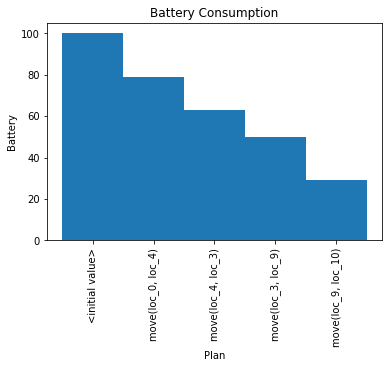

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

b = [100]
labels = ['<initial value>']
for ai in plan.actions:
  c = problem.initial_value(consumption(*ai.actual_parameters))
  b.append(b[-1] - c.constant_value())
  labels.append(str(ai))

x = list(range(len(plan.actions)+1))
plt.bar(x, b, width=1)

plt.xlabel('Plan')
plt.ylabel('Battery')
plt.xticks(x, labels, rotation='vertical')
plt.title('Battery Consumption')
plt.show()

# Beyond plan generation

`OneshotPlanner` is not the only **operation mode** we can invoke from the unified_planning, it is just one way to interact with a planning engine. Another useful functionality is `PlanValidation` that checks if a plan is valid for a problem.

In [ ]:
plan = result.plan
with PlanValidator(problem_kind=problem.kind, plan_kind=plan.kind) as validator:
    if validator.validate(problem, plan):
        print('The plan is valid')
    else:
        print('The plan is invalid')

  *** Credits ***
  * In operation mode `PlanValidator` at line 2 of `<ipython-input-12-af6de1fb604a>`, you are using the following planning engine:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.

The plan is valid


It is also possible to use the `Compiler` operation mode to create an equivalent formulation of a problem that does not use parameters for the actions. This operation mode is implemented by an internal python code, but also some engines offer advanced grounding techniques. 

In [ ]:
with Compiler(problem_kind=problem.kind, compilation_kind=CompilationKind.GROUNDING) as grounder:
    grounding_result = grounder.compile(problem, CompilationKind.GROUNDING)
    ground_problem, map_back_function = grounding_result.problem, grounding_result.map_back_action_instance

    # The map_back_function can be used to "lift" a ground plan back to the level of the original problem
    with OneshotPlanner(problem_kind=ground_problem.kind) as planner:
        ground_plan = planner.solve(ground_problem).plan
        print('Ground plan: %s' % ground_plan)
        lifted_plan = ground_plan.replace_action_instances(map_back_function)
        print('Lifted plan: %s' % lifted_plan)
        with PlanValidator(problem_kind=problem.kind, plan_kind=ground_plan.kind) as validator:
            assert validator.validate(ground_problem, ground_plan)
            assert validator.validate(problem, lifted_plan)


  *** Credits ***
  * In operation mode `OneshotPlanner` at line 6 of `<ipython-input-13-545655c22848>`, you are using the following planning engine:
  * Engine name: ENHSP
  * Developers:  Enrico Scala
  * Description: Expressive Numeric Heuristic Search Planner.

Ground plan: [move_loc_0_loc_4, move_loc_4_loc_5, move_loc_5_loc_9, move_loc_9_loc_10]
Lifted plan: [move(loc_0, loc_4), move(loc_4, loc_5), move(loc_5, loc_9), move(loc_9, loc_10)]
  *** Credits ***
  * In operation mode `PlanValidator` at line 11 of `<ipython-input-13-545655c22848>`, you are using the following planning engine:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.

